In [1]:
from google.colab import drive # Il faut pouvoir lire les fichiers CSV du Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import shutil
import os
import csv
import random

# Séparation en train, dev, test set

In [7]:
p_train = 0.9
p_val = 0.07
p_test = 0.03
n_images = 764

In [9]:
random.seed(2)
t = [0] * n_images
for i in range (n_images):
  r = random.random()
  if (r > p_train and r < p_train + p_val): t[i] = 1
  if (r >= p_train + p_val ): t[i] = 2

# Travail sur une image fixée

In [10]:
def interpret(adress):
	xmlFile = open(adress, "r")
	width = 0
	height = 0
	helmets = []
	for line in xmlFile:
		if line[9:14] == "width":
			index = 15
			while line[index] != '<':
				width = 10*width + int(line[index])
				index += 1
		elif line[9:15] == "height":
			index = 16
			while line[index] != '<':
				height = 10*height + int(line[index])
				index += 1
		elif line[9:13] == "name":
			if line[18] == 'o':
				withBool = False
			else:
				withBool = True
		elif line[13:17] == "xmin":
			xmin = 0
			index = 18
			while line[index] != '<':
				xmin = 10*xmin + int(line[index])
				index += 1
		elif line[13:17] == "ymin":
			ymin = 0
			index = 18
			while line[index] != '<':
				ymin = 10*ymin + int(line[index])
				index += 1
		elif line[13:17] == "xmax":
			xmax = 0
			index = 18
			while line[index] != '<':
				xmax = 10*xmax + int(line[index])
				index += 1
		elif line[13:17] == "ymax":
			ymax = 0
			index = 18
			while line[index] != '<':
				ymax = 10*ymax + int(line[index])
				index += 1
			helmets.append((withBool,xmin,ymin,xmax,ymax))
	
	return (width, height, len(helmets),  helmets)

In [11]:
def show_image(index_img):
  adress = "/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Images/BikesHelmets" + str(index_img) + ".png"
  data = interpret("/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Labels/BikesHelmets" + str(index_img) + ".xml")
  im = Image.open(adress)

  print(data[0],"x",data[1],"px avec", data[2], "casque(s).")
  fig, ax = plt.subplots(figsize=(15,15))
  ax.imshow(im)

  for i in range(len(data[3])):
    (casque,x,y,x2,y2) = data[3][i]
    color = "b"
    if casque: color = "r"
    rect = patches.Rectangle((x, y), x2-x, y2-y, linewidth=3, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

  plt.show()

400 x 267 px avec 4 casque(s).


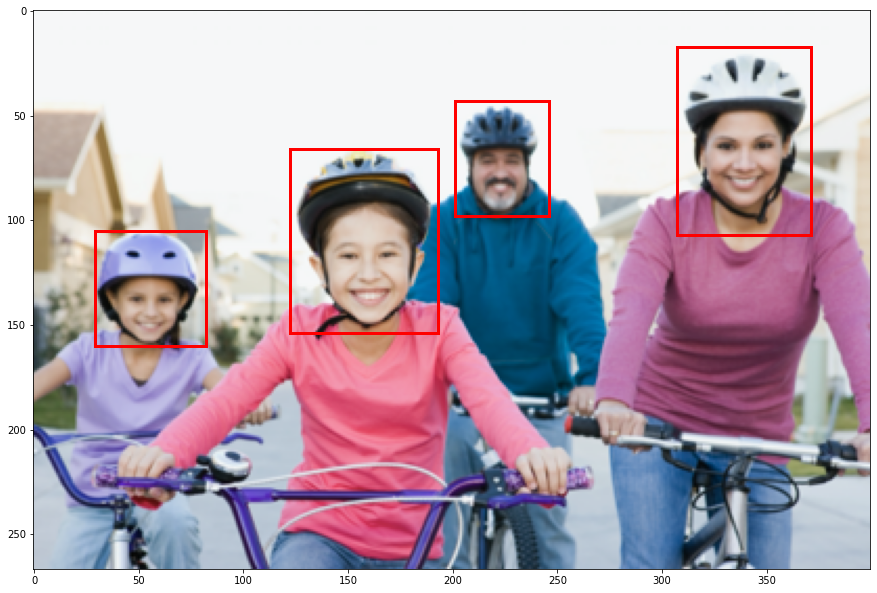

In [12]:
show_image(0)

In [14]:
n_images = 764
n_faces = 0

In [21]:
def create_faces(index_img):
  global n_faces
  n_error = 0
  adress = "/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Images/BikesHelmets" + str(index_img) + ".png"
  data = interpret("/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Labels/BikesHelmets" + str(index_img) + ".xml")
  im = Image.open(adress)
  print(index_img, data[0],"x",data[1],"px avec", data[2], "casque(s).")
  epsilon = 10
  width, height = im.size
  for i in range(len(data[3])): # on parcourt le nombre de box
    (casque,x,y,x2,y2) = data[3][i]
    if (t[index_img] == 0):
      boxes = []
      for j in range(15):
        np.random.seed(n_images * 10 * (index_img + 1) * j + 1)
        r = np.random.rand(4)
        box = (max(0, min(x - r[0] * epsilon, width)), max(0, min(height, y - r[1] * epsilon)), max(0, min(width, x2 + r[2] * epsilon)), max(0, min(height, y2 + r[3] * epsilon)))
        if (box not in boxes):
          try:
            im0 = im.crop(box = box)
            if casque: im0.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces/train/casque/face' + str(n_faces) + "_" + str(index_img) + "_" + str(casque) + ".png")
            else: im0.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces/train/sans_casque/face' + str(n_faces) + "_" + str(index_img) + "_" + str(casque) + ".png")
            n_faces += 1
            boxes.append(box)
          except:
            n_error += 1
    else:
      try:
        im0 = im.crop(box = (x, y, x2, y2))
        if (casque and t[index_img] == 1): im0.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces/val/casque/face' + str(n_faces) + "_" + str(index_img) + "_" + str(casque) + ".png")
        if (t[index_img] == 2): im0.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces/test/test/face' + str(n_faces) + "_" + str(index_img) + "_" + str(casque) + ".png")
        if (not (casque) and t[index_img] == 1): im0.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces/val/sans_casque/face' + str(n_faces) + "_" + str(index_img) + "_" + str(casque) + ".png")
        n_faces += 1
      except:
        n_error += 1
  if (t[index_img] > 0):  
    b = not (False in [data[3][i][0] for i in range (len(data[3]))])
    if (t[index_img] == 2): im.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/test/test/image' + str(index_img) + "_" + str(b) + ".png")
    if (t[index_img] == 1 and b): im.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/casque/image' + str(index_img) + "_" + str(b) + ".png")
    if (t[index_img] == 1 and not (b)): im.save('/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces_image_complete/val/sans_casque/image' + str(index_img) + "_" + str(b) + ".png")
  return n_error

In [76]:
# create_faces(0)

In [19]:
def create_all_faces():
  errors = 0
  for index_img in range (n_images):
    n_error = create_faces(index_img)
    errors += n_error
  return errors, n_faces

In [22]:
create_all_faces()

0 400 x 267 px avec 4 casque(s).
1 400 x 300 px avec 1 casque(s).
2 400 x 300 px avec 3 casque(s).
3 400 x 216 px avec 2 casque(s).
4 400 x 258 px avec 1 casque(s).
5 400 x 250 px avec 1 casque(s).
6 400 x 225 px avec 5 casque(s).
7 400 x 273 px avec 3 casque(s).
8 400 x 300 px avec 2 casque(s).
9 400 x 234 px avec 2 casque(s).
10 400 x 241 px avec 1 casque(s).
11 600 x 450 px avec 6 casque(s).
12 480 x 360 px avec 1 casque(s).
13 598 x 557 px avec 1 casque(s).
14 400 x 223 px avec 1 casque(s).
15 240 x 160 px avec 2 casque(s).
16 400 x 267 px avec 4 casque(s).
17 400 x 225 px avec 2 casque(s).
18 400 x 225 px avec 2 casque(s).
19 400 x 291 px avec 2 casque(s).
20 300 x 400 px avec 2 casque(s).
21 400 x 267 px avec 1 casque(s).
22 400 x 298 px avec 2 casque(s).
23 400 x 301 px avec 3 casque(s).
24 400 x 329 px avec 1 casque(s).
25 400 x 225 px avec 2 casque(s).
26 600 x 400 px avec 2 casque(s).
27 576 x 432 px avec 1 casque(s).
28 450 x 273 px avec 1 casque(s).
29 520 x 355 px avec 1 c

(199, 19344)

# Gestion du bug initial

In [81]:
# n_faces

18978

In [82]:
# len(Y)

18978

In [122]:
# l = []
# folder = "/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces"
# for x in os.listdir(folder):
#   l.append(int(x[4:-4:]))
# l.sort()
# print(l)
# print(len(l))

[708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907,

In [89]:
# print(Y[708:739:])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]


Il y a juste eu un bug, il faut recréer les 708 premières images, mais les labels sont déjà présents ! Finalement je supprime les 708 premières !

In [121]:
# Y = Y[708:18979]

In [123]:
# len(Y)

18271

In [126]:
folder = "/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces"
for x in os.listdir(folder):
  os.rename(folder + "/" + x, folder + "/face" + str(int(x[4:-4:]) - 708) + ".png") # On renomme à cause du bug !

In [145]:
l = []
folder = "/content/drive/MyDrive/Hackathon IA/Bike helmet detection/Faces"
for x in os.listdir(folder):
  if x[0] != 'l':
    l.append(int(x[4:-4:]))
l.sort()
print(l)
print(len(l))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [132]:
print(Y[1260:1276])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]


In [147]:
with open("/content/drive/MyDrive/Hackathon IA/Bike helmet detection/labels_faces.csv" , "w") as file:
    writer = csv.writer(file)
    for i in range (len(Y)):
      writer.writerow([i, int(Y[i])])

In [148]:
print(os.listdir(folder))

['face708.png', 'face709.png', 'face710.png', 'face711.png', 'face712.png', 'face713.png', 'face714.png', 'face715.png', 'face716.png', 'face717.png', 'face718.png', 'face719.png', 'face720.png', 'face721.png', 'face722.png', 'face723.png', 'face724.png', 'face725.png', 'face726.png', 'face727.png', 'face728.png', 'face729.png', 'face730.png', 'face731.png', 'face732.png', 'face733.png', 'face734.png', 'face735.png', 'face736.png', 'face737.png', 'face738.png', 'face739.png', 'face740.png', 'face741.png', 'face742.png', 'face743.png', 'face744.png', 'face745.png', 'face746.png', 'face747.png', 'face748.png', 'face749.png', 'face750.png', 'face751.png', 'face752.png', 'face753.png', 'face754.png', 'face755.png', 'face756.png', 'face757.png', 'face758.png', 'face759.png', 'face760.png', 'face761.png', 'face762.png', 'face763.png', 'face764.png', 'face765.png', 'face766.png', 'face767.png', 'face768.png', 'face769.png', 'face770.png', 'face771.png', 'face772.png', 'face773.png', 'face774.

In [149]:
Y

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Tru